# Project Assignment

See the webpage for supplementary descriptions.
* [link to d3 home page](https://titanbender.github.io) 
* [link to git repo](https://github.com/titanbender/titanbender.github.io)

In [ ]:
from IPython.display import VimeoVideo
VimeoVideo("211653855",width=640, height=360)

The video has a length of 03:30. The fist 20 secounds are introduction and the music is fading out in the last 15 secounds of the video.

## 1. Motivation
- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?






## 2. Basic stats. Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

In [1]:
# Used libraries
import json
import numpy as np
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import collections 
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
import datetime as dt
import geoplotlib
from geoplotlib.utils import BoundingBox
from sklearn import neighbors
import gmplot

/Users/anders/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Create JSON function 
def createJSON(my_dict, file_name):
    with open(file_name, 'w') as outfile:
        json.dump(my_dict, outfile)
        outfile.close()

In [3]:
# Create geojson
def parseJson(year,file_name):
    # number of obs. 
    tmp_DF = raw_DF[raw_DF["YEAR"] == year]
    #
    tmp_lat = list(tmp_DF["LATITUDE"])
    tmp_lon = list(tmp_DF["LONGITUDE"])
    tmp_hour = list(tmp_DF["HOUR"])
    tmp_borough = list(tmp_DF["BOROUGH"])
    # 
    N_tot = len(tmp_lat)
    
    # output
    out_dict = [{'lat': tmp_lat[ii],
                 'lon': tmp_lon[ii],
                 'r': 1} for ii in range(0,N_tot)]
    #
    createJSON(out_dict, file_name) 

In [98]:
# http://planspace.org/20151129-see_sklearn_trees_with_d3/

def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier

    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.

    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        count_labels = zip(clf.tree_.value[node_index, 0], labels)
        node['name'] = ', '.join(('{} of {}'.format(int(count), label)
                                  for count, label in count_labels))
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['name'] = '{} > {}'.format(feature, threshold)
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
    return node

In [4]:
## Data manipulation
# Load data
raw_DF = pd.read_csv("data/raw_data.csv", low_memory = False)

# Getting year
year = raw_DF["DATE"].apply(lambda x: x.split('/'))
raw_DF["YEAR"] = year.apply(lambda x: int(x[2]))

# Getting hour
hour = raw_DF["TIME"].apply(lambda x: x.split(':'))
raw_DF["HOUR"] = hour.apply(lambda x: int(x[0]))
raw_DF["TIME_DEC"] = hour.apply(lambda x: float(int(x[0]) + int(x[1])/60) )

# Getting month
month = raw_DF["DATE"].apply(lambda x: x.split('/'))
raw_DF["MONTH"] = month.apply(lambda x: int(x[0]))

# create bool variable KNN_bool = [0 or 1]. 0 if persons not are injured nor killed otherwise 1...
raw_DF['KNN_bool'] = raw_DF[['NUMBER OF PERSONS INJURED',
                             'NUMBER OF PERSONS KILLED']].apply(lambda x: 1 if (x['NUMBER OF PERSONS INJURED'] + 
                                                                                x['NUMBER OF PERSONS KILLED']) > 0 
                                                                else 0, axis=1)

# remove unused columns
raw_DF = raw_DF.drop(['ZIP CODE',
                          'LOCATION',
                          'UNIQUE KEY',
                          'ON STREET NAME',
                          'CROSS STREET NAME',
                          'OFF STREET NAME'], axis = 1)
# raw_DF.head()
# raw_DF.shape
N = raw_DF.shape[0]

In [5]:
pra_info = {}
# First day of observations
pra_info['first obs'] = min(raw_DF["DATE"])
# Last day of observations
pra_info['last obs'] = max(raw_DF["DATE"])
# 
# pra_info['unique year'] = list(set(raw_DF['YEAR']))
pra_info['unique year'] = [2013,2014,2015,2016]
#
pra_info['N'] = {}
tmp = []
for ii in pra_info['unique year']:
    pra_info['N'][ii] = len(raw_DF[raw_DF['YEAR'] == ii])
    tmp.append(pra_info['N'][ii])
# sum tot
pra_info['N']['tot'] = sum(tmp)

pra_info['unique borough'] = list(set(raw_DF['BOROUGH']))
pra_info['borough'] = {}
for ii in pra_info['unique borough']:
    pra_info['borough'][ii] = {}
    tmp = []
    for jj in pra_info['unique year']:
        pra_info['borough'][ii][jj] = len(raw_DF[(raw_DF['YEAR'] == jj) & (raw_DF['BOROUGH'] == ii)])
        tmp.append(pra_info['borough'][ii][jj])   
    # sum tot
    pra_info['borough'][ii]['tot'] = sum(tmp)
    
# obs per month
pra_info['unique months'] = list(set(raw_DF['MONTH']))
pra_info['N month'] = {}
for ii in pra_info['unique months']:
    pra_info['N month'][ii] = {}
    tmp = []
    for jj in pra_info['unique year']:
        pra_info['N month'][ii][jj] = len(raw_DF[(raw_DF['YEAR'] == jj) & (raw_DF['MONTH'] == ii)])
        tmp.append(pra_info['N month'][ii][jj])
        
    # sum tot
    pra_info['N month'][ii]['tot'] = sum(tmp)
    
# ratio
pra_info['ratio'] = {}
for ii in pra_info['unique borough']:
    pra_info['ratio'][ii] = {}
    for jj in pra_info['unique year']+['tot']:
        pra_info['ratio'][ii][jj] = pra_info['borough'][ii][jj] / pra_info['N'][jj] 
        
# ratio month
pra_info['ratio month'] = {}
for ii in pra_info['unique months']:
    pra_info['ratio month'][ii] = {}
    for jj in pra_info['unique year']:
        pra_info['ratio month'][ii][jj] = pra_info['N month'][ii][jj] / pra_info['N'][jj]
        
# obs per day
pra_info['unique days'] = list(set(raw_DF['DATE']))
pra_info['No. days'] = {}
for ii in pra_info['unique days']:
    pra_info['No. days'][ii] = len(raw_DF[raw_DF['DATE'] == ii])
    
# avg
# counting
tmp = [int(pra_info['No. days'].keys()[ii].split('/')[2]) for ii in range(0, len(pra_info['No. days']))]
tmp_days = collections.Counter(tmp)
tmp_days['tot'] = len(pra_info['No. days'])

pra_info['avg day'] = {}
for ii in pra_info['unique year']+['tot']:
        pra_info['avg day'][ii] =  pra_info['N'][ii] / tmp_days[ii]
        
pra_info['avg year'] = {}
for ii in pra_info['unique year']:
        pra_info['avg year'][ii] =  pra_info['N'][ii] / len(pra_info['unique year'])



In [ ]:
# Pratical data information prints
print "First day of observations:", min(raw_DF["DATE"])
print "Last day of observations:", max(raw_DF["DATE"])
print "Total number of obs. in mentioned period:" , len(raw_DF['DATE'])
print ""
print "Observations per month:"
print pra_info['N month']
print ""
print "Accidents per district:"
print pra_info['borough']
print ""
print "Geographic area of each district:"
print "To be done.... "
print ""
print "Ratio between geographic area per district and number of accidents"
print pra_info['ratio']
print ""
print "Ratio between accidents and months"
print pra_info['ratio month']
print ""
print "Types of accidents"
print "To be done.... "
print ""
print "Average accidents per year:"
print pra_info['avg year']
print ""
print "Average accidents per day:"
print pra_info['avg day'] #pra_info['N']['tot'] / len(pra_info['No. days'])
print ""
print "Day with most accidents"
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=True)[0]
print ""
print "Day with least accidents"
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=False)[0]
print ""
print "Top 10 days with most accidents:" 
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=True)[0:10]
print ""
print "Top 10 days with least accidents:" 
print sorted(pra_info['No. days'].items(), key=lambda x: x[1], reverse=False)[0:10]



## 3. Theory. Which theoretical tools did you use?
- Describe which machine learning tools you use and why the tools you've chosen are right for the problem you're solving.
- Talk about your model selection. How did you split the data in to test/training. Did you use cross validation?
- Explain the model performance. How did you measure it? Are your results what you expected?

## 4. Visualizations
- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell?

### Intro plot

In [ ]:
# Heat Map
# Manually insetting API key and the accidents coordinates
## gmap = gmplot.GoogleMapPlotter(np.mean(raw_DF["LATITUDE"]), np.mean(raw_DF["LONGITUDE"]), 10.5)
## gmap.heatmap(list(raw_DF["LATITUDE"]), list(raw_DF["LONGITUDE"]), threshold=5, radius=5)
## gmap.draw("data/heatmap.html")

# decrease obs 
idx = (raw_DF.sample(frac=0.5).index)

# dict with coordinates
coor = {}
coor['lon'] = list(raw_DF["LONGITUDE"].iloc[idx])
coor['lat'] = list(raw_DF["LATITUDE"].iloc[idx])
coor['N'] = len(idx)
# write to file for later copy paste.
f = open('data/heatmap.txt', 'w')
[f.write('new google.maps.LatLng({0},{1}),\n'.format(coor['lat'][ii],coor['lon'][ii])) for ii in range(coor['N'])]
f.close() 

### Bar plot

In [ ]:
# Time frame
tmp_x_key = ["00:00-00:59","01:00-01:59","02:00-02:59","03:00-03:59","04:00-04:59","05:00-05:59",
             "06:00-06:59","07:00-07:59","08:00-08:59","09:00-09:59","10:00-10:59","11:00-11:59",
             "12:00-12:59","13:00-13:59","14:00-14:59","15:00-15:59","16:00-16:59","17:00-17:59",
             "18:00-18:59","19:00-19:59","20:00-20:59","21:00-21:59","22:00-22:59","23:00-23:59"]

# init lists
bar_dict_NYC = []
bar_dict_BRONX = []
bar_dict_BROOKLYN = []
bar_dict_STATEN_ISLAND = []
bar_dict_MANHATTAN = []
bar_dict_QUEENS = []
# injured
bar_dict_NYC_inj = []
bar_dict_BRONX_inj = []
bar_dict_BROOKLYN_inj = []
bar_dict_STATEN_ISLAND_inj = []
bar_dict_MANHATTAN_inj = []
bar_dict_QUEENS_inj = []
# killed
bar_dict_NYC_kill = []
bar_dict_BRONX_kill = []
bar_dict_BROOKLYN_kill = []
bar_dict_STATEN_ISLAND_kill = []
bar_dict_MANHATTAN_kill = []
bar_dict_QUEENS_kill = []

# loop through each time frame
for ii in range(0,24):
    #print ii
    tmp_borough = {}
    tmp_borough_inj = {}
    tmp_borough_kill = {}
    for jj in pra_info['unique borough']:
        #print 's'
        tmp_borough[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii)])
        tmp_borough_inj[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii) & 
                                     (raw_DF['NUMBER OF PERSONS INJURED'] > 0)])
        tmp_borough_kill[jj] = len(raw_DF[(raw_DF['BOROUGH'] == jj) & 
                                     (raw_DF['HOUR'] == ii) & 
                                     (raw_DF['NUMBER OF PERSONS KILLED'] > 0)])
        
    # sum all for given time slot
    tmp_sum = np.sum(tmp_borough.values())
    tmp_sum_inj = np.sum(tmp_borough_inj.values())
    tmp_sum_kill = np.sum(tmp_borough_kill.values())
    
    # append time slot to list
    bar_dict_NYC.append({'key': tmp_x_key[ii], 'value': tmp_sum})
    bar_dict_BRONX.append({'key': tmp_x_key[ii], 'value': tmp_borough['BRONX']})
    bar_dict_BROOKLYN.append({'key': tmp_x_key[ii], 'value': tmp_borough['BROOKLYN']})
    bar_dict_STATEN_ISLAND.append({'key': tmp_x_key[ii], 'value': tmp_borough['STATEN ISLAND']})
    bar_dict_MANHATTAN.append({'key': tmp_x_key[ii], 'value': tmp_borough['MANHATTAN']})
    bar_dict_QUEENS.append({'key': tmp_x_key[ii], 'value': tmp_borough['QUEENS']})
    
    # only injured
    bar_dict_NYC_inj.append({'key': tmp_x_key[ii], 'value': tmp_sum_inj})
    bar_dict_BRONX_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['BRONX']})
    bar_dict_BROOKLYN_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['BROOKLYN']})
    bar_dict_STATEN_ISLAND_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['STATEN ISLAND']})
    bar_dict_MANHATTAN_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['MANHATTAN']})
    bar_dict_QUEENS_inj.append({'key': tmp_x_key[ii], 'value': tmp_borough_inj['QUEENS']})
    
    # killed
    bar_dict_NYC_kill.append({'key': tmp_x_key[ii], 'value': tmp_sum_kill})
    bar_dict_BRONX_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['BRONX']})
    bar_dict_BROOKLYN_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['BROOKLYN']})
    bar_dict_STATEN_ISLAND_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['STATEN ISLAND']})
    bar_dict_MANHATTAN_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['MANHATTAN']})
    bar_dict_QUEENS_kill.append({'key': tmp_x_key[ii], 'value': tmp_borough_kill['QUEENS']})
    
# create bar jsons 
createJSON(bar_dict_NYC, 'data/bar/bar_dict_NYC.json')
createJSON(bar_dict_BRONX, 'data/bar/bar_dict_BRONX.json')
createJSON(bar_dict_BROOKLYN, 'data/bar/bar_dict_BROOKLYN.json')
createJSON(bar_dict_STATEN_ISLAND, 'data/bar/bar_dict_STATEN_ISLAND.json')
createJSON(bar_dict_MANHATTAN, 'data/bar/bar_dict_MANHATTAN.json')
createJSON(bar_dict_QUEENS, 'data/bar/bar_dict_QUEENS.json')

createJSON(bar_dict_NYC_inj, 'data/bar/bar_dict_NYC_inj.json')
createJSON(bar_dict_BRONX_inj, 'data/bar/bar_dict_BRONX_inj.json')
createJSON(bar_dict_BROOKLYN_inj, 'data/bar/bar_dict_BROOKLYN_inj.json')
createJSON(bar_dict_STATEN_ISLAND_inj, 'data/bar/bar_dict_STATEN_ISLAND_inj.json')
createJSON(bar_dict_MANHATTAN_inj, 'data/bar/bar_dict_MANHATTAN_inj.json')
createJSON(bar_dict_QUEENS_inj, 'data/bar/bar_dict_QUEENS_inj.json')

createJSON(bar_dict_NYC_kill, 'data/bar/bar_dict_NYC_kill.json')
createJSON(bar_dict_BRONX_kill, 'data/bar/bar_dict_BRONX_kill.json')
createJSON(bar_dict_BROOKLYN_kill, 'data/bar/bar_dict_BROOKLYN_kill.json')
createJSON(bar_dict_STATEN_ISLAND_kill, 'data/bar/bar_dict_STATEN_ISLAND_kill.json')
createJSON(bar_dict_MANHATTAN_kill, 'data/bar/bar_dict_MANHATTAN_kill.json')
createJSON(bar_dict_QUEENS_kill, 'data/bar/bar_dict_QUEENS_kill.json')

### Time Series

In [ ]:
# Time Series
ts_json_ped = []; ts_json_cyc = []; ts_json_mot = [];
ts_json_NYC = []

# loop for each day
for dd in pra_info['unique days']:
    # init temp dict
    tmp_ped = {}
    tmp_cyc = {}
    tmp_mot = {}
    
    # init dict level for NYC
    tmp_ped['NYC'] = {}; tmp_cyc['NYC'] = {}; tmp_mot['NYC'] = {}

    # Setting date
    tmp_ped['NYC']['date'] = dd; tmp_cyc['NYC']['date'] = dd; tmp_mot['NYC']['date'] = dd
    
    # init inital value to later sum
    tmp_ped['NYC']['inj'] = 0; tmp_cyc['NYC']['inj'] = 0; tmp_mot['NYC']['inj'] = 0
    tmp_ped['NYC']['kill'] = 0; tmp_cyc['NYC']['kill'] = 0; tmp_mot['NYC']['kill'] = 0
    tmp_ped['NYC']['tot'] = 0; tmp_cyc['NYC']['tot'] = 0; tmp_mot['NYC']['tot'] = 0
    # loop for each borough
    for bb in pra_info['unique borough']:
        # init dict
        tmp_ped[bb] = {}
        tmp_cyc[bb] = {}
        tmp_mot[bb] = {}
        # add date
        tmp_ped[bb]['date'] = dd
        tmp_cyc[bb]['date'] = dd
        tmp_mot[bb]['date'] = dd
        # find indices for unique day and unique borough
        tmp_idx = list(raw_DF[(raw_DF['DATE'] == dd) & (raw_DF['BOROUGH'] == bb)].index)
        #
        tmp_ped[bb]['inj'] = np.sum(raw_DF['NUMBER OF PEDESTRIANS INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_ped[bb]['kill'] = np.sum(raw_DF['NUMBER OF PEDESTRIANS KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_ped[bb]['tot'] = (tmp_ped[bb]['inj'] + tmp_ped[bb]['kill'])
        
        tmp_cyc[bb]['inj'] = np.sum(raw_DF['NUMBER OF CYCLIST INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_cyc[bb]['kill'] = np.sum(raw_DF['NUMBER OF CYCLIST KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_cyc[bb]['tot'] = (tmp_cyc[bb]['inj'] + tmp_cyc[bb]['kill'])
        
        tmp_mot[bb]['inj'] = np.sum(raw_DF['NUMBER OF MOTORIST INJURED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_mot[bb]['kill'] = np.sum(raw_DF['NUMBER OF MOTORIST KILLED'].iloc[tmp_idx])# / len(tmp_idx) * 100
        tmp_mot[bb]['tot'] = (tmp_mot[bb]['inj'] + tmp_mot[bb]['kill'])
        
        # summing to NYC
        tmp_ped['NYC']['inj'] += tmp_ped[bb]['inj']
        tmp_ped['NYC']['kill'] += tmp_ped[bb]['kill']
        tmp_ped['NYC']['tot'] += tmp_ped[bb]['tot']
        
        tmp_cyc['NYC']['inj'] += tmp_cyc[bb]['inj']
        tmp_cyc['NYC']['kill'] += tmp_cyc[bb]['kill']
        tmp_cyc['NYC']['tot'] += tmp_cyc[bb]['tot']
        
        tmp_mot['NYC']['inj'] += tmp_mot[bb]['inj']
        tmp_mot['NYC']['kill'] += tmp_mot[bb]['kill']
        tmp_mot['NYC']['tot'] += tmp_mot[bb]['tot']
        
    # append day and info to the json list
    ts_json_ped.append(tmp_ped)
    ts_json_cyc.append(tmp_cyc)
    ts_json_mot.append(tmp_mot)

# create jsons
for bb in pra_info['unique borough'] + ['NYC']:
    # tot
    ##tmp = [ts_json_tot[ii][bb] for ii in range(0,len(ts_json_tot))]
    ##tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    ##createJSON(tmp,'data/ts/ts_tot_' + bb + '.json')
    # ped
    tmp = [ts_json_ped[ii][bb] for ii in range(len(ts_json_ped))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_ped_' + bb + '.json')
    # cyc
    tmp = [ts_json_cyc[ii][bb] for ii in range(len(ts_json_cyc))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_cyc_' + bb + '.json')
    # mot
    tmp = [ts_json_mot[ii][bb] for ii in range(len(ts_json_mot))]
    tmp.sort(key=lambda x: dt.datetime.strptime(x['date'], '%m/%d/%Y'))
    createJSON(tmp,'data/ts/ts_mot_' + bb + '.json')

### KNN

In [ ]:
# Create dict for prediction tool
knn_dict = {}
knn_dict['lat'] = list(raw_DF['LATITUDE'])
knn_dict['lat_min_max'] = [np.min(knn_dict['lat']), np.max(knn_dict['lat'])]
knn_dict['lon'] = list(raw_DF['LONGITUDE'])
knn_dict['lon_min_max'] = [np.min(knn_dict['lon']), np.max(knn_dict['lon'])]
knn_dict['time'] = list(raw_DF['TIME_DEC'])
knn_dict['month'] = list(raw_DF['MONTH'])

knn_dict['class'] = list(raw_DF['KNN_bool'])
knn_dict['N'] = len(knn_dict['class'])

# For prediction 
knn_dict['X'] = np.array([[knn_dict['lat'][ii], knn_dict['lon'][ii], knn_dict['time'][ii], knn_dict['month'][ii]] for ii in range(0,knn_dict['N'])])
knn_dict['y'] = np.array([knn_dict['class'][ii] for ii in range(0,knn_dict['N'])])

# create knn_json for D3
knn_json = [{'lat': knn_dict['lat'][ii],
             'lon': knn_dict['lon'][ii],
             'class': knn_dict['class'][ii]} for ii in range(0,len(knn_dict['class']))]

createJSON(knn_json, 'data/knn_json.json') 

# 
tmp = collections.Counter(knn_dict['class'])
print 'Non fatal:                           {0:.3f}%'.format(tmp.values()[0] / np.sum(tmp.values()) * 100)
print 'Fatal (injured / killed) accidents:  {0:.3f}%'.format(tmp.values()[1] / np.sum(tmp.values()) * 100)

In [ ]:
# Estimate model parameters using cross validation

# Maximum number of neighbors
K = 50
N = knn_dict['N']
# K-fold crossvalidation
K_fold = 10
CV = cross_validation.KFold(N, K_fold, shuffle = False)
#CV = cross_validation.LeaveOneOut(N)

errors = np.zeros((N, K))
i = 0
for train_index, test_index in CV:
    print 'Crossvalidation fold: {0}/{1}'.format(i + 1, CV.n_folds)
    
    # extract training and test set for current CV fold
    X_train = knn_dict['X'][train_index,:]
    y_train = knn_dict['y'][train_index]
    X_test = knn_dict['X'][test_index,:]
    y_test = knn_dict['y'][test_index]

    # Fit classifier and classify the test points (consider 1 to 40 neighbors)
    for k in range(1, K + 1):
        knclassifier = KNeighborsClassifier(n_neighbors = k);
        knclassifier.fit(X_train, y_train);
        y_est = knclassifier.predict(X_test);
        errors[i, k - 1] = np.sum(y_est != y_test)
    # 
    i +=1
    
# Plot the classification error rate
plt.plot(range(1,errors.shape[1] + 1), (100 * np.sum(errors,0) / N).tolist())
plt.xlabel('Number of neighbors')
plt.ylabel('Classification error rate (%)')
plt.show()

Comments on plot...

In [ ]:
# Fitting KKN for the complate observations
knn_dict['k_opt'] = np.argmin(np.sum(errors,0)) + 1
knn_dict['knn_opt_fit'] = KNeighborsClassifier(n_neighbors = knn_dict['k_opt']);

knn_dict['knn_opt_fit'].fit(knn_dict['X'], knn_dict['y']);
lat_min, lat_max = knn_dict['lat_min_max']
lon_min, lon_max = knn_dict['lon_min_max']

# Plot the decision boundary. For that, we will asign a color to each
# create prediction grid
# meshgrid size
# h = 0.0001
# h = 0.001
# xx, yy = np.arange(lat_min, lat_max, h), np.arange(lon_min, lon_max, h)
# pre = [[xx[ii], yy[jj]] for ii in range(0,len(xx)) for jj in range(0,len(yy))]


# use complete data to classify based upon cross validated 
pre = knn_dict['X'].tolist()
# prediction
Z = knn_dict['knn_opt_fit'].predict(pre)

# 
pre_knn_dict = {}
pre_knn_dict['lat'] = [pre[ii][0] for ii in range(len(Z))]
pre_knn_dict['lon'] = [pre[ii][1] for ii in range(len(Z))]
pre_knn_dict['time'] = [pre[ii][2] for ii in range(len(Z))]
pre_knn_dict['month'] = [pre[ii][3] for ii in range(len(Z))]
pre_knn_dict['class'] = [Z[ii] for ii in range(len(Z))]

# json
def r_col(x):
    if x == 1: tmp_col = 'rgba(255,0,0, 0.25)'
    else: tmp_col = 'rgba(0,255,0, 0.25)'
    return tmp_col

knn_opt_json = [{'lat': pre_knn_dict['lat'][ii],
                 'lon': pre_knn_dict['lon'][ii],
                 'class': pre_knn_dict['class'][ii]} for ii in range(0,len(pre_knn_dict['class']))]
#
createJSON(knn_opt_json, 'data/knn_opt_json.json') 

#
tmp = collections.Counter(pre_knn_dict['class'])
print 'Non fatal:                           {0:.3f}%'.format(tmp.values()[0] / np.sum(tmp.values()) * 100)
print 'Fatal (injured / killed) accidents:  {0:.3f}%'.format(tmp.values()[1] / np.sum(tmp.values()) * 100)

Comments on unblanced data.. how it affects predictions

### Decision Tree

In [117]:
tmp_raw = raw_DF

tmp_raw.shape

(601313, 28)

In [123]:
# exercise 6.1.2

from sklearn import tree
dtree_dict = {}
uni_borough = list(set(tmp_raw['BOROUGH']))
dtree_dict['borough'] = [uni_borough.index(tmp_raw['BOROUGH'][ii]) for ii in range(tmp_raw.shape[0])]

dtree_dict['lat'] = list(tmp_raw['LATITUDE'])
dtree_dict['lon'] = list(tmp_raw['LONGITUDE'])

dtree_dict['time'] = list(tmp_raw['TIME_DEC'])
dtree_dict['month'] = list(tmp_raw['MONTH'])

dtree_dict['class'] = list(tmp_raw['KNN_bool'])
dtree_dict['N'] = len(dtree_dict['class'])

# For prediction 
#feature_names = ['borough', 'lat','lon','time','month']
feature_names = ['borough','time','month']
dtree_dict['X'] = np.array([[dtree_dict['borough'][ii],
                             #dtree_dict['lat'][ii], 
                             #dtree_dict['lon'][ii], 
                             dtree_dict['time'][ii], 
                             dtree_dict['month'][ii]] for ii in range(dtree_dict['N'])])


target_names = ['Non Fatal','Fatal']
dtree_dict['y'] = np.array([dtree_dict['class'][ii] for ii in range(dtree_dict['N'])])

Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10


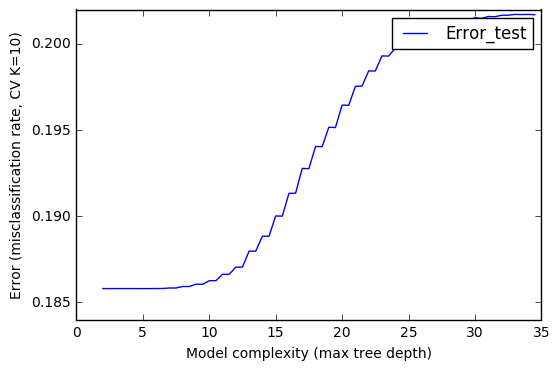

In [124]:
# Estimate model parameters using cross validation

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 35, 0.5)


# K-fold crossvalidation
K_fold = 10
CV = cross_validation.KFold(dtree_dict['N'], K_fold, shuffle = False)

Error_train = np.empty((len(tc),K_fold))
Error_test = np.empty((len(tc),K_fold))

k = 0
for train_index, test_index in CV:
    print 'Crossvalidation fold: {0}/{1}'.format(k + 1, K_fold)
    
    # extract training and test set for current CV fold
    X_train = dtree_dict['X'][train_index,:]
    y_train = dtree_dict['y'][train_index]
    X_test = dtree_dict['X'][test_index,:]
    y_test = dtree_dict['y'][test_index]

    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels (t)
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = t)
        dtc = dtc.fit(X_train, y_train)

        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        
        # Evaluate misclassification rate over train/test data (in this CV fold)
        Error_test[i, k] = np.sum(y_est_test != y_test) / len(y_test)
        Error_train[i, k] = np.sum(y_est_train != y_train) / len(y_train)
    
    k+=1
    
from pylab import *
# Plot the classification error rate
#f = figure(); f.hold(True)
#boxplot(Error_test.T)
#xlabel('Model complexity (max tree depth)')
#ylabel('Test error across CV folds, K={0})'.format(K_fold))

f = figure(); f.hold(True)
#plot(tc, Error_train.mean(1))
plot(tc, Error_test.mean(1))
xlabel('Model complexity (max tree depth)')
ylabel('Error (misclassification rate, CV K={0})'.format(K_fold))
#legend(['Error_train','Error_test'])
legend(['Error_test'])
    
show()


In [120]:


t = [2,3,4,5]
for tt in t:
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = tt)
    dtc = dtc.fit(dtree_dict['X'], dtree_dict['y'])
    dtree_json = rules(dtc, feature_names, target_names)
    createJSON(dtree_json, 'data/dtree/dtree_json_' + str(tt) + '.json')


In [121]:
#name: "container thing",
dtree_json['name']

'borough > 1.5'

2.3219280948873622

In [100]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

data = load_iris()

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(data.data, data.target)

rules(clf, data.feature_names, data.target_names)

{'children': [{'children': [{'children': [{'name': '0 of setosa, 0 of versicolor, 43 of virginica'},
      {'name': '0 of setosa, 1 of versicolor, 2 of virginica'}],
     'name': 'petal length (cm) > 4.85000038147'},
    {'children': [{'name': '0 of setosa, 2 of versicolor, 4 of virginica'},
      {'name': '0 of setosa, 47 of versicolor, 1 of virginica'}],
     'name': 'petal length (cm) > 4.94999980927'}],
   'name': 'petal width (cm) > 1.75'},
  {'name': '50 of setosa, 0 of versicolor, 0 of virginica'}],
 'name': 'petal length (cm) > 2.45000004768'}

### Weather correlation

In [ ]:
raw_weather_DF = pd.read_csv("data/raw_data_weather.csv", low_memory = False)

print raw_weather_DF.shape

#raw_weather_DF = raw_weather_DF([['DATE', 'PRCP', 'TMIN', 'TMAX', 'TOBS']]
list(raw_weather_DF)



#raw_weather_DF = raw_weather_DF[raw_weather_DF['MDPR'] == -9999.0]

print raw_weather_DF.shape

In [ ]:
list(raw_weather_DF)

In [ ]:
# Getting year
date = raw_weather_DF["DATE"].apply(lambda x: [str(x)[4:6],str(x)[6:8],str(x)[:4]])
raw_weather_DF["YEAR"] = year.apply(lambda x: int(x[2]))

# Getting hour
##hour = raw_DF["TIME"].apply(lambda x: x.split(':'))
##raw_DF["HOUR"] = hour.apply(lambda x: int(x[0]))
##raw_DF["TIME_DEC"] = hour.apply(lambda x: float(int(x[0]) + int(x[1])/60) )

# Getting month
##month = raw_DF["DATE"].apply(lambda x: x.split('/'))
##raw_DF["MONTH"] = month.apply(lambda x: int(x[0]))

In [ ]:
tmp = 'WESF'
raw_weather_DF[['DATE',tmp]].head()

In [ ]:

#print set(raw_weather_DF[tmp])
print collections.Counter(raw_weather_DF[tmp])

In [ ]:
First day of observations: 01/01/2013
Last day of observations: 12/31/2016

## 5. Discussion Think critically about your creation
- What went well?,
- What is still missing? What could be improved?, Why?